In [1]:
# --- Install required packages (uncomment if needed) ---
!pip install pandapower numpy matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 7.5 MB/s eta 0:00:00


In [2]:
# --- Import Libraries ---
import pandapower as pp
import pandapower.networks as pn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

Loaded IEEE 118-bus system.
Enter weather mode (normal, rainy, summer): Summer

Running 10,000 simulations under 'SUMMER' conditions...


Simulating: 100%|██████████| 10000/10000 [08:50<00:00, 18.85it/s]



Voltage Statistics under SUMMER Conditions:
--------------------------------------------------
Bus 0:
  Mean Voltage        : 0.955
  Std Deviation       : 0.000
  Voltage < 0.95 pu   : 0.00%
  Voltage > 1.05 pu   : 0.00%

Bus 1:
  Mean Voltage        : 0.971
  Std Deviation       : 0.001
  Voltage < 0.95 pu   : 0.00%
  Voltage > 1.05 pu   : 0.00%

Bus 2:
  Mean Voltage        : 0.968
  Std Deviation       : 0.001
  Voltage < 0.95 pu   : 0.00%
  Voltage > 1.05 pu   : 0.00%

Bus 3:
  Mean Voltage        : 0.998
  Std Deviation       : 0.000
  Voltage < 0.95 pu   : 0.00%
  Voltage > 1.05 pu   : 0.00%

Bus 4:
  Mean Voltage        : 1.002
  Std Deviation       : 0.000
  Voltage < 0.95 pu   : 0.00%
  Voltage > 1.05 pu   : 0.00%

Bus 5:
  Mean Voltage        : 0.990
  Std Deviation       : 0.000
  Voltage < 0.95 pu   : 0.00%
  Voltage > 1.05 pu   : 0.00%

Bus 6:
  Mean Voltage        : 0.989
  Std Deviation       : 0.000
  Voltage < 0.95 pu   : 0.00%
  Voltage > 1.05 pu   : 0.00%

Bus 7:
 

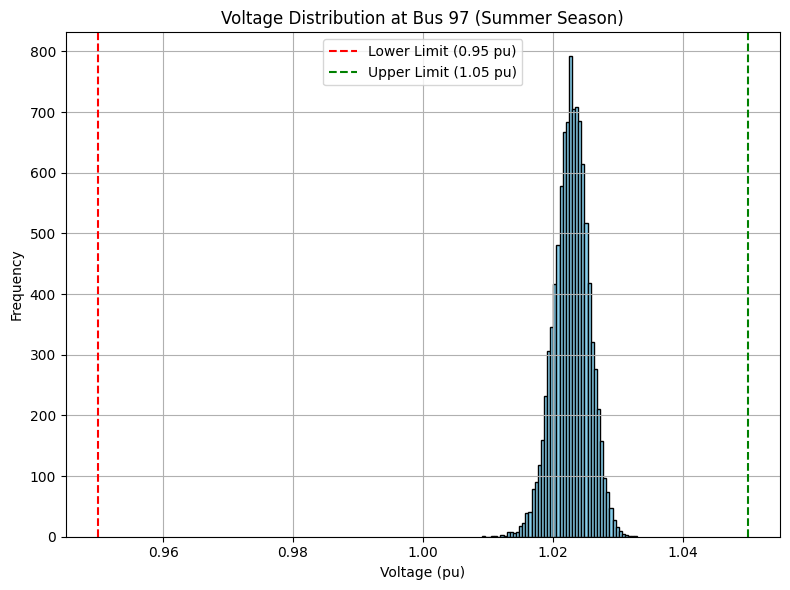

In [4]:
# ------------------ Step 1: Load IEEE 118-Bus Network ------------------
net = pn.case118()
print(f"Loaded IEEE {len(net.bus)}-bus system.")

# ------------------ Step 2: User Input for Weather Mode ------------------
valid_modes = ['normal', 'rainy', 'summer']
weather_mode = input("Enter weather mode (normal, rainy, summer): ").strip().lower()

while weather_mode not in valid_modes:
    print(" Invalid input. Please enter one of: normal, rainy, summer.")
    weather_mode = input("Enter weather mode (normal, rainy, summer): ").strip().lower()

# Set uncertainty levels based on weather
if weather_mode == "normal":
    std_dev_percent_load = 0.2
    std_dev_percent_gen = 0.1
    std_dev_percent_q = 0.3
elif weather_mode == "rainy":
    std_dev_percent_load = 0.25
    std_dev_percent_gen = 0.3
    std_dev_percent_q = 0.4
elif weather_mode == "summer":
    std_dev_percent_load = 0.3
    std_dev_percent_gen = 0.2
    std_dev_percent_q = 0.35

print(f"\nRunning 10,000 simulations under '{weather_mode.upper()}' conditions...")

# ------------------ Step 3: Setup Base Values ------------------
mean_loads = net.load['p_mw'].copy()
mean_q = net.load['q_mvar'].copy()
mean_gens = net.gen['p_mw'].copy()

# ------------------ Step 4: Monte Carlo Simulation ------------------
n_simulations = 10000
voltages_at_buses = {bus: [] for bus in net.bus.index}

for _ in trange(n_simulations, desc="Simulating"):
    # ---- Sample active power for loads (P) ----
    sampled_p = np.random.normal(loc=mean_loads, scale=std_dev_percent_load * np.abs(mean_loads))
    sampled_p = np.clip(sampled_p, 0.01, None)
    net.load['p_mw'] = sampled_p

    # ---- Sample reactive power for loads (Q) ----
    sampled_q = np.random.normal(loc=mean_q, scale=std_dev_percent_q * np.abs(mean_q))
    net.load['q_mvar'] = sampled_q

    # ---- Sample generator outputs (P) ----
    sampled_gens = np.random.normal(loc=mean_gens, scale=std_dev_percent_gen * np.abs(mean_gens))
    sampled_gens = np.clip(sampled_gens, 0.01, None)
    net.gen['p_mw'] = sampled_gens

    # ---- Run Power Flow ----
    try:
        pp.runpp(net)
        for bus in net.bus.index:
            voltages_at_buses[bus].append(net.res_bus.vm_pu.at[bus])
    except:
        continue

# ------------------ Step 5: Voltage Statistics ------------------
buses_to_analyze = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
91, 92, 93, 94, 95, 96, 97, 98, 99, 100,
101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
111, 112, 113, 114, 115, 116, 117]

print(f"\nVoltage Statistics under {weather_mode.upper()} Conditions:\n" + "-"*50)
for bus in buses_to_analyze:
    v = np.array(voltages_at_buses[bus])
    mean_v = np.mean(v)
    std_v = np.std(v)
    low_pct = (v < 0.95).mean() * 100
    high_pct = (v > 1.05).mean() * 100

    print(f"Bus {bus}:")
    print(f"  Mean Voltage        : {mean_v:.3f}")
    print(f"  Std Deviation       : {std_v:.3f}")
    print(f"  Voltage < 0.95 pu   : {low_pct:.2f}%")
    print(f"  Voltage > 1.05 pu   : {high_pct:.2f}%\n")

# ------------------ Step 6: User Input for Bus Plot ------------------
try:
    selected_bus = int(input(f"Enter a bus number (0 to {net.bus.index[-1]}) to plot: "))
    while selected_bus not in net.bus.index:
        print(" Invalid bus number.")
        selected_bus = int(input(f"Enter a valid bus number (0 to {net.bus.index[-1]}): "))
except ValueError:
    selected_bus = 4
    print(" Invalid input. Defaulting to Bus 4.")

# ------------------ Step 7: Plot Histogram ------------------
v_data = np.array(voltages_at_buses[selected_bus])

plt.figure(figsize=(8, 6))
plt.hist(v_data, bins=50, color='skyblue', edgecolor='black')
plt.axvline(0.95, color='red', linestyle='--', label='Lower Limit (0.95 pu)')
plt.axvline(1.05, color='green', linestyle='--', label='Upper Limit (1.05 pu)')
plt.title(f"Voltage Distribution at Bus {selected_bus} ({weather_mode.capitalize()} Season)")
plt.xlabel("Voltage (pu)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
plot_filename = f"voltage_distribution_bus{selected_bus}_{weather_mode}_case118.png"
plt.savefig(plot_filename, dpi=300)
print(f"Saved plot as {plot_filename}")
plt.show()